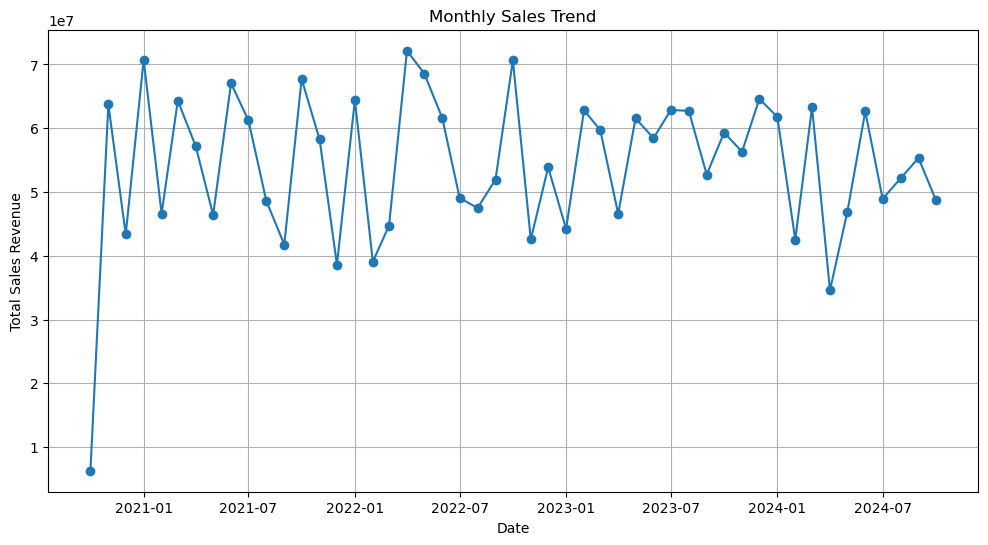

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07240D+00    |proj g|=  1.57438D-01

At iterate    5    f=  7.92736D+00    |proj g|=  3.12376D-02

At iterate   10    f=  7.91696D+00    |proj g|=  2.89024D-03

At iterate   15    f=  7.91693D+00    |proj g|=  1.86948D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   1.484D-05   7.917D+00
  F =   7.9169254669434466     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


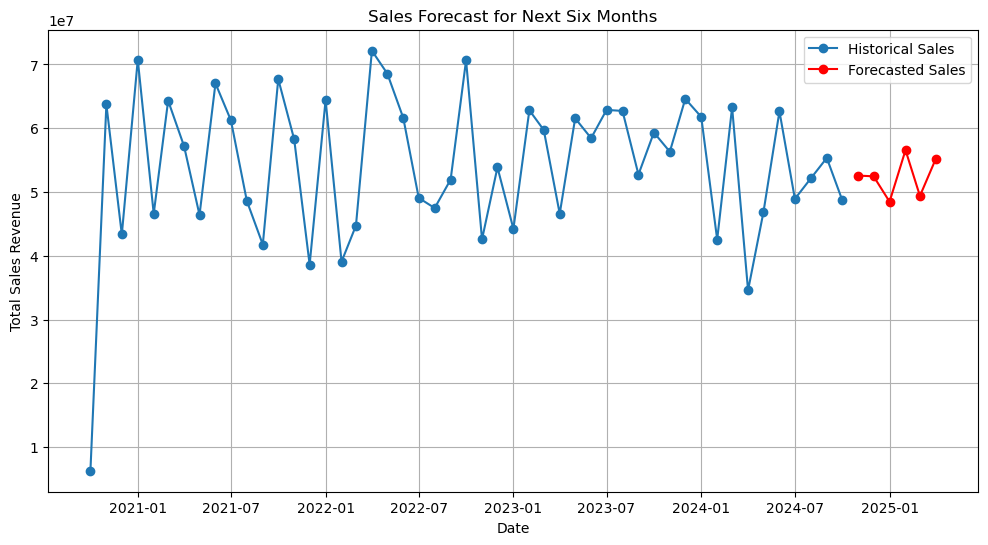

Forecasted Sales for the Next Six Months:
2024-11-01    5.257688e+07
2024-12-01    5.246231e+07
2025-01-01    4.848150e+07
2025-02-01    5.657014e+07
2025-03-01    4.938929e+07
2025-04-01    5.523487e+07
Freq: MS, Name: predicted_mean, dtype: float64


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

prod_data = pd.read_csv("/Users/samleonor/Desktop/ITDA/DMP:MLPA/ProdData.csv")
trans_data = pd.read_csv("/Users/samleonor/Desktop/ITDA/DMP:MLPA/TransData.csv")

# Clean Product Data
prod_data.dropna(subset=['Product_ID'], inplace=True)
prod_data['Product_ID'] = prod_data['Product_ID'].astype(int)
prod_data['Product_Price'] = prod_data['Product_Price'].str.replace(r'[^\d.]', '', regex=True)
prod_data['Product_Price'] = pd.to_numeric(prod_data['Product_Price'], errors='coerce')

# Clean Transaction Data
trans_data.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
trans_data['Transaction_Date'] = pd.to_datetime(trans_data['Transaction_Date'], errors='coerce')
trans_data.dropna(subset=['Transaction_ID', 'Product_ID'], inplace=True)
trans_data['Transaction_ID'] = trans_data['Transaction_ID'].astype(int)
trans_data['Product_ID'] = trans_data['Product_ID'].astype(int)
trans_data.loc[:, 'Quantity'] = trans_data['Quantity'].fillna(trans_data['Quantity'].median())
trans_data.loc[:, 'Total_Cost'] = trans_data['Quantity'] * trans_data['Product_Price']

# Merge product and transaction data
merged_data = trans_data.merge(prod_data, on='Product_ID', how='left')

# Extract date-based features
merged_data['Year'] = merged_data['Transaction_Date'].dt.year
merged_data['Month'] = merged_data['Transaction_Date'].dt.month
merged_data['Day'] = merged_data['Transaction_Date'].dt.day
merged_data['DayOfWeek'] = merged_data['Transaction_Date'].dt.dayofweek

# ## Aggregate sales data per month
monthly_sales = merged_data.groupby(['Year', 'Month'])['Total_Cost'].sum().reset_index()
monthly_sales['Date'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(day=1))
monthly_sales.set_index('Date', inplace=True)
monthly_sales = monthly_sales[['Total_Cost']]

# ## Plot the historical sales trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['Total_Cost'], marker='o', linestyle='-')
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales Revenue")
plt.grid(True)
plt.show()

# ## Train a SARIMA Model
sarima_model = SARIMAX(monthly_sales, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
fitted_model = sarima_model.fit()

# ## Forecast for the next six months
forecast_period = 6
forecast = fitted_model.get_forecast(steps=forecast_period)
forecast_index = pd.date_range(start=monthly_sales.index[-1], periods=forecast_period+1, freq='MS')[1:]
forecast_values = forecast.predicted_mean

# ## Plot the forecasted sales
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales['Total_Cost'], marker='o', linestyle='-', label="Historical Sales")
plt.plot(forecast_index, forecast_values, marker='o', linestyle='-', label="Forecasted Sales", color='red')
plt.title("Sales Forecast for Next Six Months")
plt.xlabel("Date")
plt.ylabel("Total Sales Revenue")
plt.legend()
plt.grid(True)
plt.show()

print("Forecasted Sales for the Next Six Months:")
print(forecast_values)